## part 1 : data acquisition + cleanup

In [662]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from torch.utils.data import TensorDataset, DataLoader
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataloader import default_collate

elephant_data = pd.read_csv("lfonts/ELEPHANT.csv")

# display(elephant_data)

def filter_df(df):
    filtered = df[(df['m_label']>= 34) & (df['m_label']<=125)]
    pixel_columns = [col for col in df.columns if col.startswith('r') and 'c' in col]
    keep_columns = ['m_label'] + pixel_columns

    filtered = filtered[keep_columns]
    return filtered

filtered_elephant_data = filter_df(elephant_data)



display(filtered_elephant_data)

,m_label,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
135,125,8,83,83,83,120,165,165,171,173,...,91,91,69,6,1,1,1,1,1,1
136,124,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
137,123,1,1,1,1,1,1,6,9,76,...,173,173,193,217,165,120,83,83,83,8
138,122,1,219,255,255,255,255,255,255,160,...,160,160,201,255,255,255,255,255,255,110
139,121,52,109,220,255,255,255,255,255,255,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,38,1,1,1,1,1,1,1,108,220,...,185,69,1,1,1,1,1,1,1,1
907,37,1,1,1,30,112,161,161,161,54,...,1,1,50,67,67,32,1,1,1,1
908,36,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
909,35,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


(368, 20, 20)
(368,)


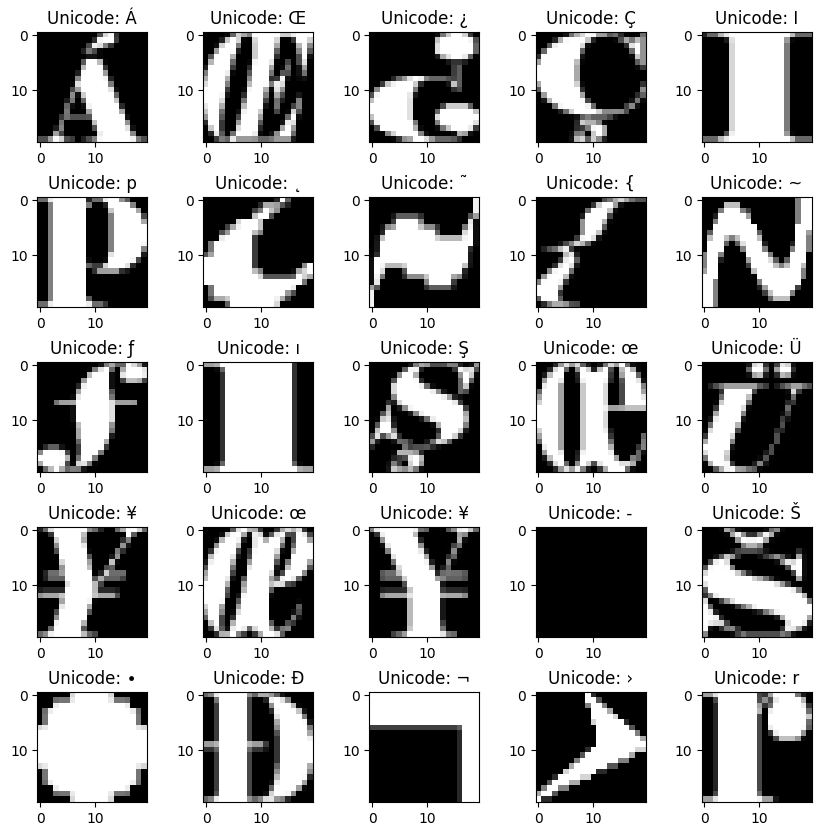

In [663]:
# creating dicitionaries for mapping the 

def dictionaries(df):
    #grabs the unique values and sorts them in ascending order
    unique_unicode_v = sorted(df['m_label'].unique())
    #unicode is they key and index is the value in the dictionary
    unicode_to_index = {unicode: index for index, unicode in enumerate(unique_unicode_v)}
    #reverse mapping of the unicode and index
    index_to_unicode = {index: unicode for unicode, index in unicode_to_index.items()}
    return unicode_to_index, index_to_unicode

unicode_to_index, index_to_unicode = dictionaries(elephant_data)


def transform(df, unicode_to_index):

    pixel_columns = [col for col in df.columns if col.startswith('r') and 'c' in col]
    #normalizing pixel value
    df[pixel_columns] = df[pixel_columns]/256.0

    #extracting the pixel data as a numpy array
    Xs = df[pixel_columns].values.reshape(-1,20,20)

    #transforming unicode label to indices
    Ys = np.array([unicode_to_index[unicode] for unicode in df['m_label'].values])

    return Xs, Ys


Xs, Ys = transform(filtered_elephant_data, unicode_to_index)

print(Xs.shape)
print(Ys.shape)

def print_unicode_mapping(index_to_unicode):
    for index, unicode in index_to_unicode.items():
        print(f"index: {index}, unicode: {unicode} char: {chr(unicode)}")

#print_unicode_mapping(index_to_unicode)

num_to_print = 25

random = np.random.choice(len(Xs), num_to_print, replace=False)

plt.figure(figsize= (10, 10))
for i, idx in enumerate(random):
    plt.subplot( 5, 5, i+1 )
    plt.imshow(X[idx, : , :], cmap='gray', interpolation='none')
    plt.title(f'Unicode: {chr(index_to_unicode[Y[idx]])}')
    plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

plt.show()




## part 2 : build a pytorch network

In [664]:



class CNN(nn.Module):

    #setting up layers and components of the CNN
    def __init__(self):
        super(CNN, self).__init__()
        # Set up 1st convolutional layer
        c1Out = 8
        c2Out = 16
        # Uses 6 filters, each w. kernel size of 3x3 pixels. 
        # The input has 1 channel (grayscale image). The output of this layer will be 6 feature maps
        self.conv1 = nn.Conv2d( 1, c1Out, 3 ) 
                
        self.pool = nn.MaxPool2d( 2, 2 ) # set up max pooling to be a 2x2 block
        
        # Set up 2nd convolutional layer
        # Uses 16 filters, each w. kernel size of 3x3 pixels. 
        # The input has 6 feature maps. The output of this layer will be 16 feature maps        
        self.conv2 = nn.Conv2d( c1Out, c2Out, 3 )
        
        # Set up 1st dense layer 
        # 3x3 grid per each of the 16 feature maps from conv2
        self.pooledOutputSize = c2Out * 3 * 3 
        self.fc1 = nn.Linear( self.pooledOutputSize, 120 )
        
        #Set up 2nd and 3rd dense layers, which continue to refine the outputs towards the final classification layer
        self.fc2 = nn.Linear( 120, 84 )
        self.fc3 = nn.Linear( 84, 10 ) # predicts one of setSize classes (number of unique characters)


    def forward(self, x): # "batch" of images
      #x is 4D tensor:  (batch size, width, height, #channels (1, grayscale image))
        #after conv1:  (batch size, width adjusted, height adjusted, conv1 # outputs)
        #after max pool: (batch size, width/2, height/2, conv1 # outputs)

        x = self.conv1(x)

        x = F.relu(x)
    
        x = self.pool(x)

        #split into 2 lines above
        #x = self.pool(F.relu(self.conv1(x)))  #apply convolution filter, then run it through relu activation function
        x = self.pool(F.relu(self.conv2(x))) #ditto
        #print(x.shape)

        #turn the 5x5xc2Out array into a single 1xN array.  The dense layers expect a 1D thing
        x = x.view(-1, self.num_flat_features(x))

        x = F.relu(self.fc1(x)) #apply dense layer 1
        x = F.relu(self.fc2(x)) #and dense layer 2, using ReLU activation
        x = self.fc3(x) #final dense layer.  No activation function on this
        return x
    
    #compute the output size after our convolution layers
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features





In [665]:
#my model to be trained
#epochs: number of complete passes through the entire dataset
def train(my_model, epochs, my_data):
    criterion = nn.CrossEntropyLoss() #measure error for classification
    
    #use the ADAM optimizer to find the best weights
    optimizer = optim.Adam(my_model.parameters(), lr= 1e-4)

    #loading data and get in the right format
    trainloader = DataLoader(my_data, batch_size=8, shuffle= True, num_workers=0)

    my_model.train()
    
    #loop over the dataset multiple times
    for epoch in range(epochs):

        running_loss = 0.0
        for inputs , labels in trainloader:
            #get the inputs; data is a lost of [inputs, labels]
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            #forward+backward+optimize
            outputs = my_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            #print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:
                print('[%d,%5d] loss: #.3f' % (epoch + 1, i+1, running_loss/2000))
                running_loss = 0.0
    print('finished training!')

#preparing training and testing data:


x_tensor = torch.tensor(Xs, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(Ys, dtype=torch.long)

x_train, x_test, y_train, y_test = train_test_split(x_tensor, y_tensor, random_state=1, test_size = 0.9)

training_data = TensorDataset(x_train, y_train)
testing_data = TensorDataset(x_test, y_test)

    #training here
#

device = ("mps" if torch.backends.mps.is_available() else "cpu")
print("device: ", device)
net = CNN().to(device=device)
train(net, 15, training_data)


device:  mps
finished training!


## Step 3: exploration and evaluation

Evaluating...
Accuracy of the network on the test images: 1.20 %


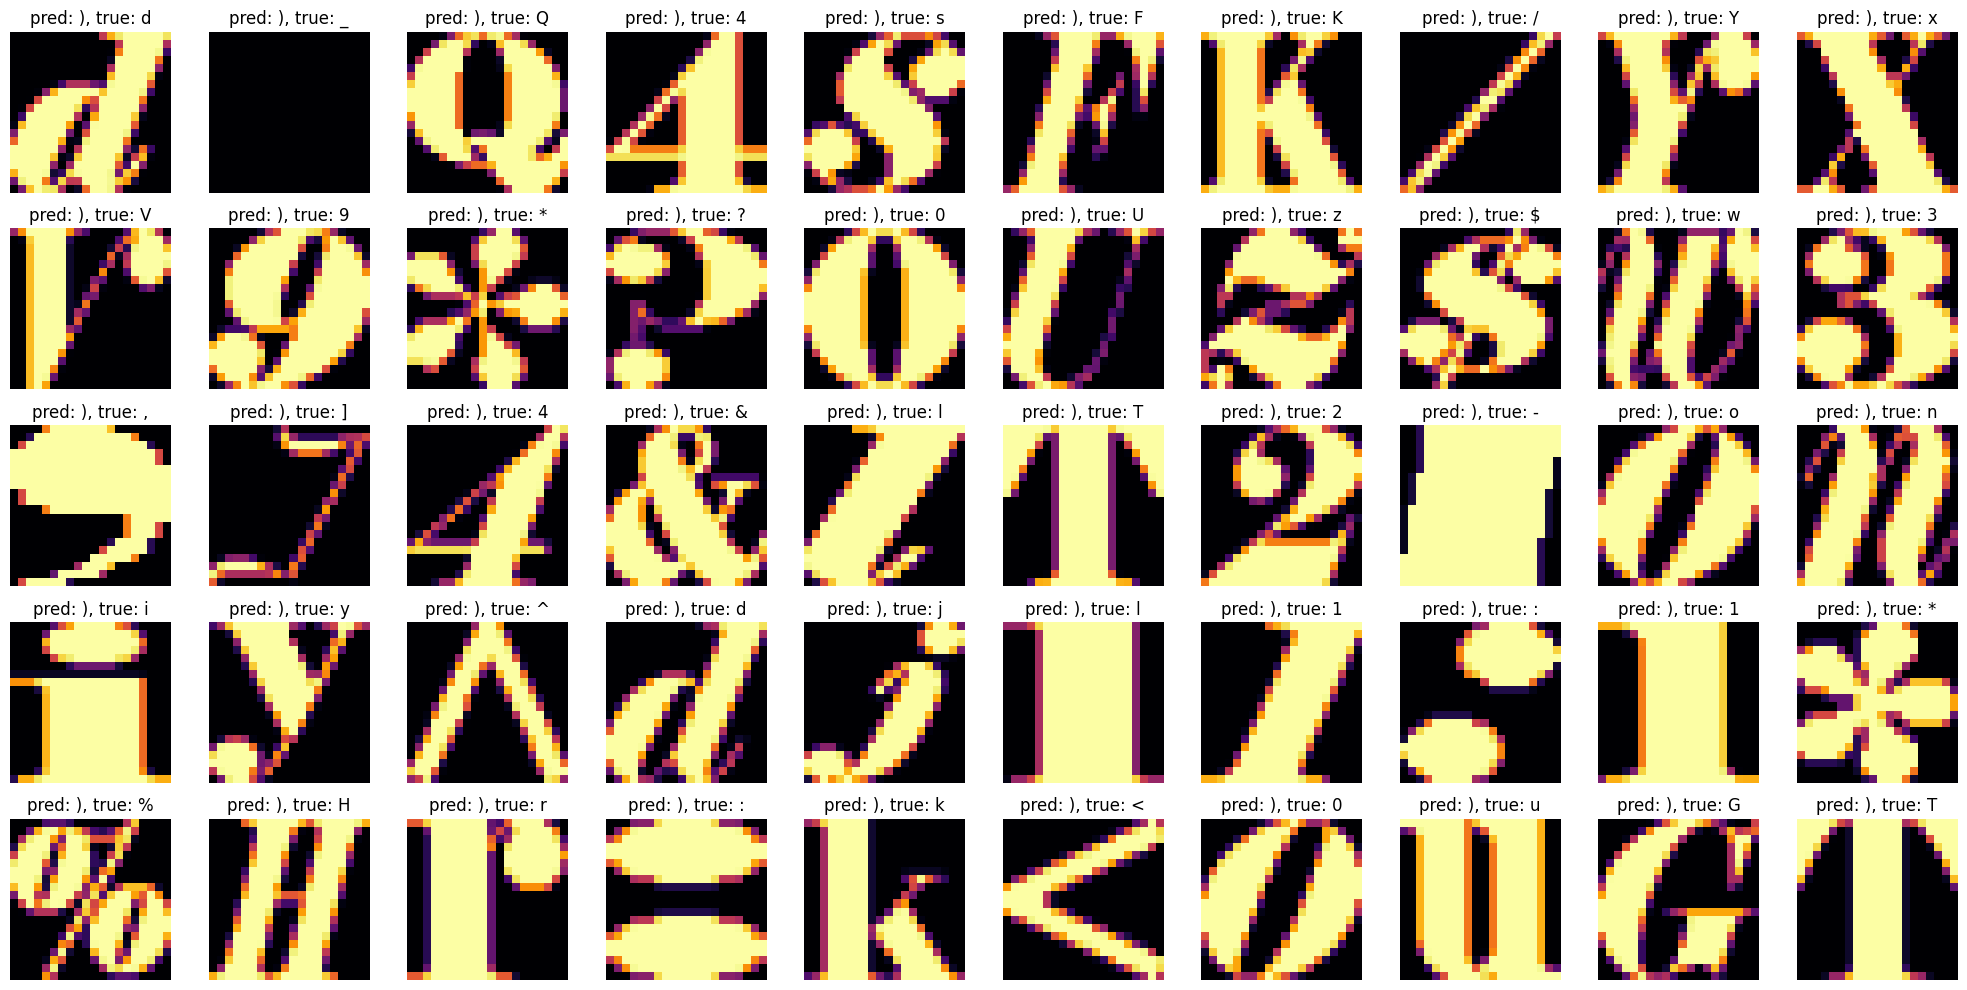

In [666]:
# Function to evaluate the model on test data
def evaluate(model, test_data, index_to_unicode):
    testloader = DataLoader(test_data, batch_size=8, shuffle=False)  # DataLoader for test data
    correct = 0
    total = 0
    incorrect_images = []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # Move data to device (CPU or GPU)
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs.data, 1)  # Get predicted labels

            #print("Predicted labels:", predicted)
            #print("True labels:", labels)

            total += labels.size(0)  # Total number of labels
            correct += (predicted == labels).sum().item()  # Count correct predictions

             # Visualization of incorrectly classified images
            for i in range(len(predicted)):
                if predicted[i] != labels[i]:
                    incorrect_images.append((images[i, 0].cpu(), predicted[i].item(), labels[i].item()))


    # Calculate accuracy
    accuracy = 100 * correct / total
    print('Accuracy of the network on the test images: %.2f %%' % accuracy)

    plot_incorrect_images(incorrect_images, index_to_unicode)


def plot_incorrect_images(incorrect_images, index_to_unicode):
    num_images = len(incorrect_images)
    rows = 5
    cols = 10
    plt.figure(figsize=(cols * 2, rows * 2))
    
    for i in range(min(num_images, rows * cols)):
        image, predicted_label, true_label = incorrect_images[i]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image.numpy(), cmap='inferno')
        if predicted_label in index_to_unicode and true_label in index_to_unicode:
            plt.title(f'pred: {chr(index_to_unicode[predicted_label])}, true: {chr(index_to_unicode[true_label])}')
        else:
            plt.title(f'uk: pred {predicted_label}, true: {true_label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print("Using device:", device)

# Assuming `net` is your CNN model instance
net = CNN().to(device=device)  # Move model to device
#print(net)  # Print model architecture

# Assuming `x_test` and `y_test` are your test data tensors
testing_data = TensorDataset(x_test, y_test)  # Create a dataset from test tensors

print("Evaluating...")
evaluate(net, testing_data, index_to_unicode)  # Evaluate the model on test data



## **Evaluate the network using cross validation (splitting data into training/testing). What is its accuracy?**


## Create and train a different network topology (add more convolution layers, experiment with normalization (batch normalization or dropout), explore other types/sizes of layer). Try to find a topology that works better than the one described above.

training...
finished training!
evaluating...
Accuracy of the network on the test images: 0.30 %


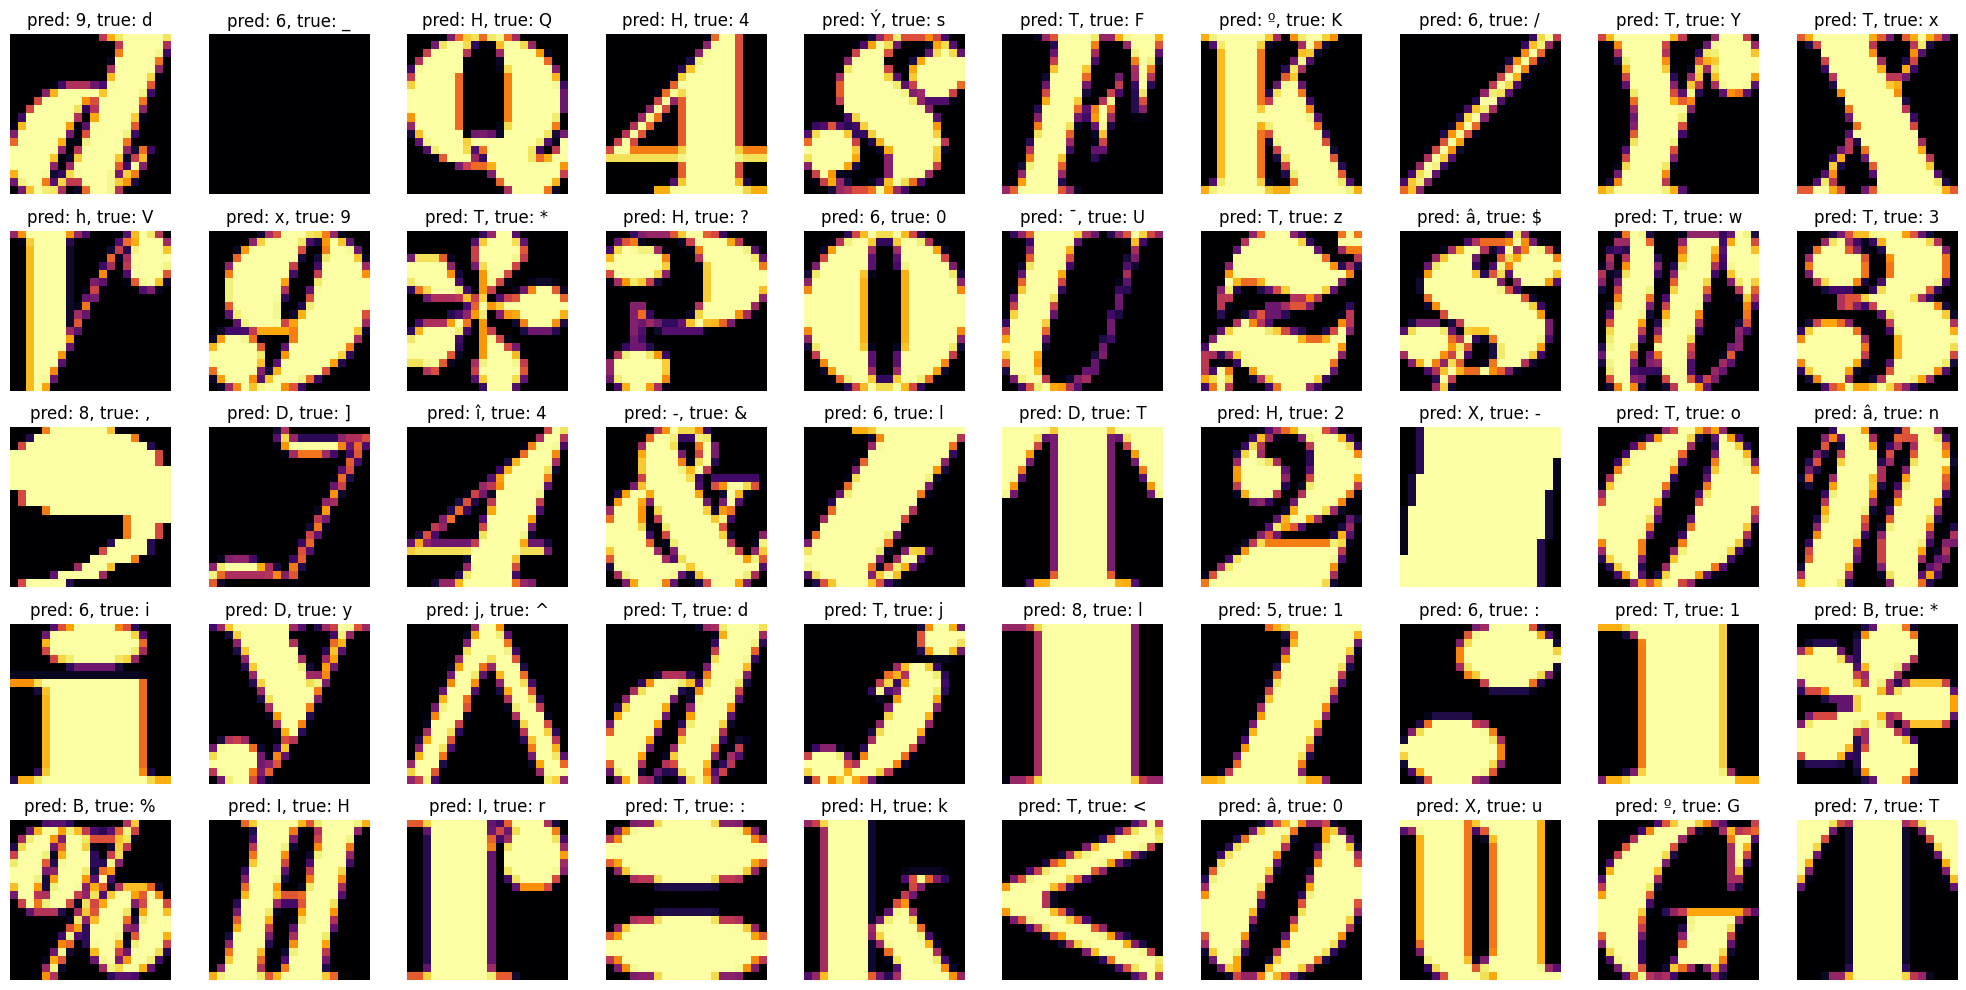

In [667]:
num_classes = len(unicode_to_index)  # Ensure this matches your output layer size

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        c1Out = 32
        c2Out = 64
        c3Out = 128

        self.conv1 = nn.Conv2d(1, c1Out, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(c1Out)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(c1Out, c2Out, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(c2Out)
        self.dropout2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(c2Out, c3Out, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(c3Out)
        self.dropout3 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(c3Out * 2 * 2, 256)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout5 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, num_classes)  # Adjusted to the number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = F.relu(self.fc2(x))
        x = self.dropout5(x)
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


new_net = ImprovedCNN().to(device=device)
print("training...")
train(new_net, 15, training_data)
print("evaluating...")
evaluate(new_net, testing_data, index_to_unicode)



## Test the accuracy of your network with character inputs from a DIFFERENT font set. How does it perform?

x_tensor_franklin shape: torch.Size([2208, 1, 20, 20])
y_tensor_franklin shape: torch.Size([2208])
Training data size: 1987
Testing data size: 221
training new net ...
finished training!
evaluating new net ...
Accuracy of the network on the test images: 33.03 %


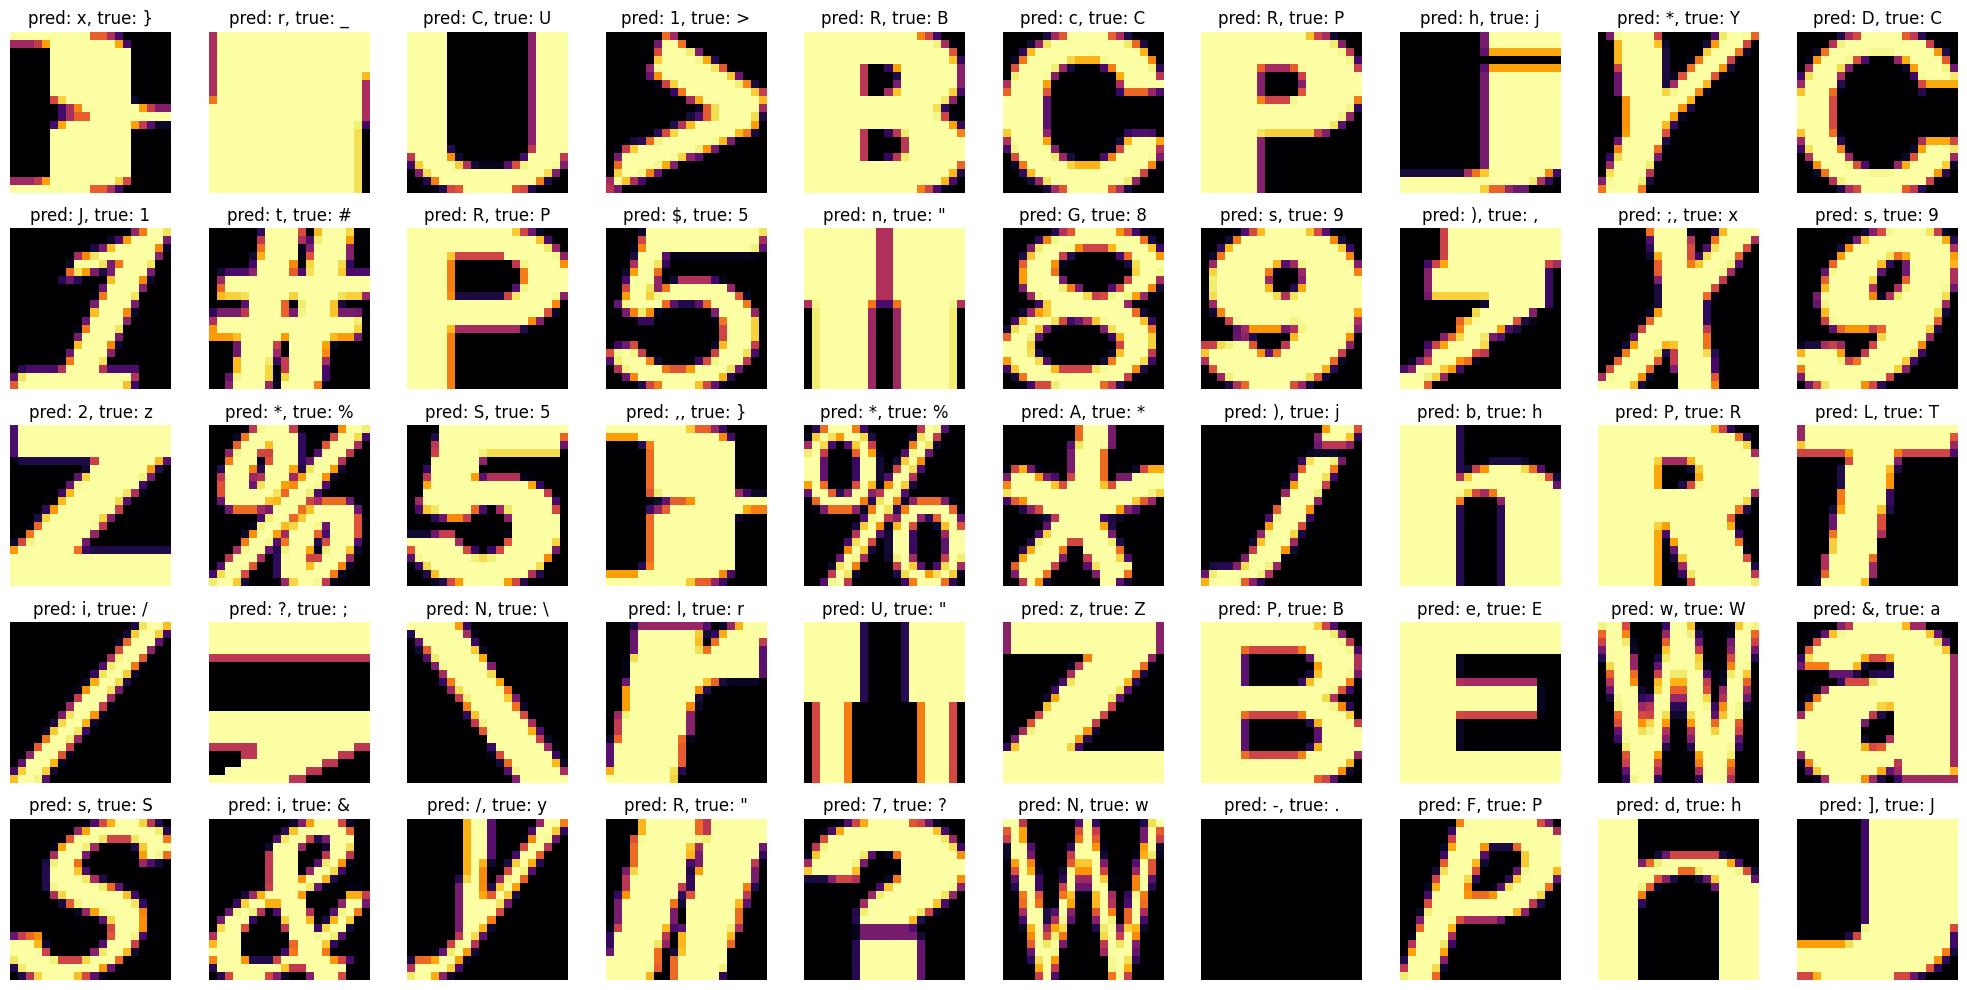

In [668]:


# Read and filter Franklin data
franklin_df = pd.read_csv("lfonts/FRANKLIN.csv")
filtered_franklin = filter_df(franklin_df)
franklin_unicode_to_index, franklin_index_to_unicode = dictionaries(filtered_franklin)

# Transform data
XsFrank, YsFrank = transform(filtered_franklin, franklin_unicode_to_index)

# Reshape and convert to tensors
Xs_franklin = np.reshape(XsFrank, (-1, 1, 20, 20))  # Ensure the shape matches the expected input of the network
x_tensor_franklin = torch.tensor(Xs_franklin, dtype=torch.float32)
y_tensor_franklin = torch.tensor(YsFrank, dtype=torch.int64)  # Ensure correct data type for targets

# Verify tensor sizes
print(f"x_tensor_franklin shape: {x_tensor_franklin.shape}")
print(f"y_tensor_franklin shape: {y_tensor_franklin.shape}")

# Split data into training and testing sets
x_train_franklin, x_test_franklin, y_train_franklin, y_test_franklin = train_test_split(
    x_tensor_franklin, y_tensor_franklin, random_state=42, test_size=0.1
)  # Adjust test_size if needed

# Create TensorDatasets
franklin_training = TensorDataset(x_train_franklin, y_train_franklin)
franklin_testing = TensorDataset(x_test_franklin, y_test_franklin)

# Check TensorDataset creation
print(f"Training data size: {len(franklin_training)}")
print(f"Testing data size: {len(franklin_testing)}")


frank_new_net = ImprovedCNN().to(device=device)
# Training and evaluation
print("training new net ...")
train(frank_new_net, 15, franklin_training)
print("evaluating new net ...")
evaluate(frank_new_net, franklin_testing, franklin_index_to_unicode)




### my new network on a different font `Franklin` has an accuracy of about 36%. this is sigificantly better than my results with `Elephant` font. I believe this is mostly due to the design of the Elephant Characters being harder to train on.

## Train your best network on inputs from the data from at least 2 different fonts. How does your accuracy compare to the 1-font case? What accuracy do you see when testing with inputs from a font you didn't train on?

x_tensor_combined shape: torch.Size([2576, 1, 20, 20])
y_tensor_combined shape: torch.Size([2576])
Training data size: 2318
Testing data size: 258
High Tower testing data size: 368
Training combined net ...
finished training!
Evaluating combined net ...
Accuracy of the network on the test images: 10.33 %


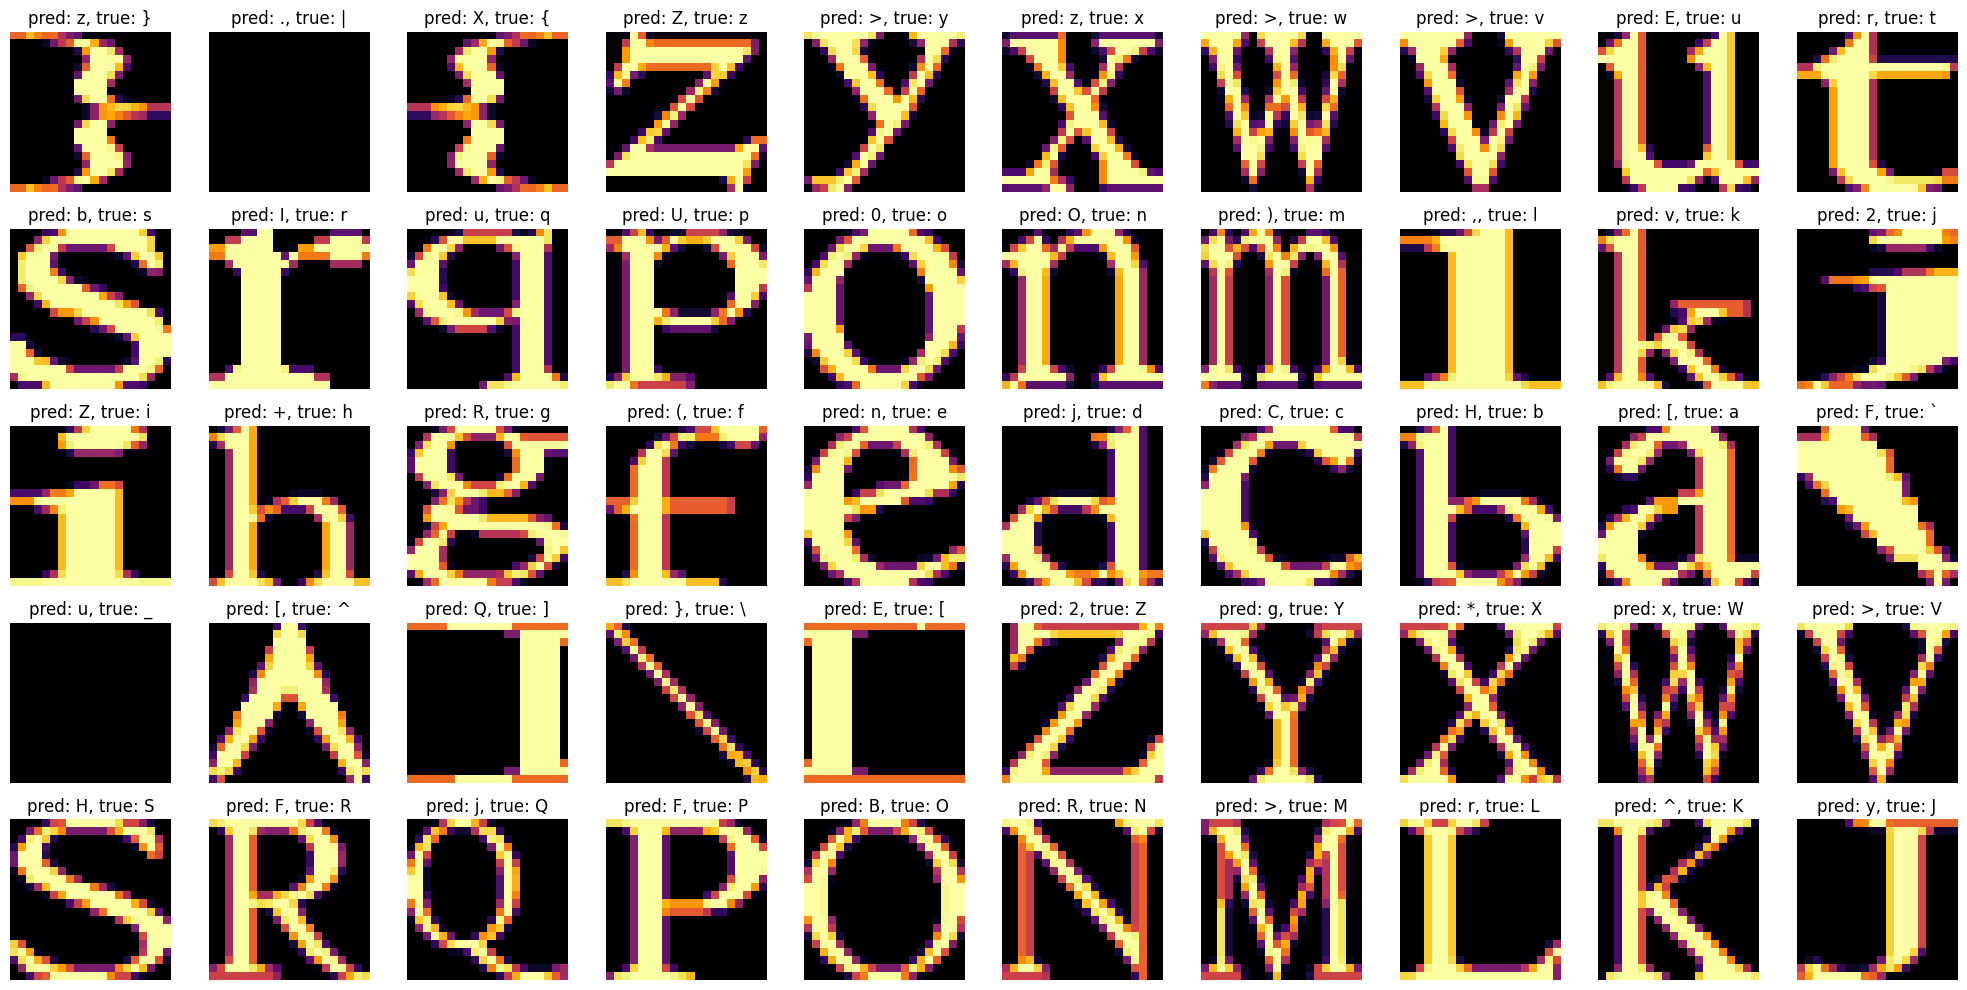

In [669]:
# Read and filter Gadugi data
gadugi_df = pd.read_csv("lfonts/GADUGI.csv")
filtered_gadugi = filter_df(gadugi_df)
gadugi_unicode_to_index, gadugi_index_to_unicode = dictionaries(filtered_gadugi)

# Combine the Unicode mappings from both datasets
combined_unicode_to_index = {**gadugi_unicode_to_index, **franklin_unicode_to_index}
combined_index_to_unicode = {index: unicode for unicode, index in combined_unicode_to_index.items()}

# Transform data
XsGadugi, YsGadugi = transform(filtered_gadugi, combined_unicode_to_index)
XsFranklin, YsFranklin = transform(filtered_franklin, combined_unicode_to_index)

# Combine datasets
Xs_combined = np.concatenate([XsGadugi, XsFranklin], axis=0)
Ys_combined = np.concatenate([YsGadugi, YsFranklin], axis=0)

# Reshape and convert to tensors
Xs_combined = np.reshape(Xs_combined, (-1, 1, 20, 20))  # Ensure the shape matches the expected input of the network
x_tensor_combined = torch.tensor(Xs_combined, dtype=torch.float32)
y_tensor_combined = torch.tensor(Ys_combined, dtype=torch.int64)  # Ensure correct data type for targets

# Verify tensor sizes
print(f"x_tensor_combined shape: {x_tensor_combined.shape}")
print(f"y_tensor_combined shape: {y_tensor_combined.shape}")

# Split data into training and testing sets
x_train_combined, x_test_combined, y_train_combined, y_test_combined = train_test_split(
    x_tensor_combined, y_tensor_combined, random_state=42, test_size=0.1
)

# Create TensorDatasets
combined_training = TensorDataset(x_train_combined, y_train_combined)
combined_testing = TensorDataset(x_test_combined, y_test_combined)

# Check TensorDataset creation
print(f"Training data size: {len(combined_training)}")
print(f"Testing data size: {len(combined_testing)}")

# Read and filter High Tower data
hightower_df = pd.read_csv("lfonts/HIGH TOWER.csv")
filtered_hightower = filter_df(hightower_df)

# Transform High Tower data using combined mappings (assuming High Tower is not included in training)
XsHightower, YsHightower = transform(filtered_hightower, combined_unicode_to_index)

# Reshape and convert to tensors
Xs_hightower = np.reshape(XsHightower, (-1, 1, 20, 20))  # Ensure the shape matches the expected input of the network
x_tensor_hightower = torch.tensor(Xs_hightower, dtype=torch.float32)
y_tensor_hightower = torch.tensor(YsHightower, dtype=torch.int64)  # Ensure correct data type for targets

# Create TensorDataset for High Tower
hightower_testing = TensorDataset(x_tensor_hightower, y_tensor_hightower)

# Check TensorDataset creation
print(f"High Tower testing data size: {len(hightower_testing)}")


# Initialize and train the network
combined_net = ImprovedCNN().to(device=device)
print("Training combined net ...")
train(combined_net, 15, combined_training)

# Evaluate the network
print("Evaluating combined net ...")
evaluate(combined_net, hightower_testing, combined_index_to_unicode)


### For this part, I trained on the `Franklin` dataset and the `Gadugi` dataset. I then tested on the `High Tower` dataset which has not been trained on. The accuracy of this network was about 12%. This is shown to be worse than the previously trained and tested network with just `Franklin`.

## Take a look at some of the characters that have been misclassified. Do you notice any patterns? The network only produces the relative probabilities that the input is any of the possible characters. Can you find examples where the network is unsure of the result?
 
### From all of the datasets and networks I trained on, symbols and numbers seem to be misclassified the most. symbols such as `@` , `%`, `&`, and `$` are often misclassified as well. The `%` sign is often misclassified as a `g` or `&`. Many of these misclassifications could also be due to the stranger and more unique fonts I chose. This also could occur if these inputs do not appear often within the training dataset, meaning the net may have no way to classify the character correctly.

